# COVID-19 Worldwide report analysis

Utilizes the daily data reporting from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE):
https://systems.jhu.edu/. This is pulled from time series maintained at Github repo:
https://github.com/CSSEGISandData/COVID-19.  

Using the introductory Data Science Tables (for reference see http://data8.org/datascience/tables.html) of introductory courses.

On 3/23 the timeseries moved and US state level data is no longer present.

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Parsing and cleaning
def denan(v):
    return v if v != 'nan' else np.nan

def clean(tbl):
    for lbl in tbl.labels:
        tbl[lbl] = tbl.apply(denan, lbl)

def is_state(name):
    return not ',' in name
def is_county(name):
    return ',' in name
def getstate(name):
    county, state = name.split(', ')
    return state
def getcounty(name):
    county, state = name.split(', ')
    return county

# Tools for working with timestamps
def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, "%m/%d/%y") < datetime.datetime.strptime(day2, "%m/%d/%y")

# Projecting growth rates

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, "%m/%d/%y") + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, "%m/%d/%y")

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
        
    day = trend.last('Day')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [3]:
# Tools for working with content
def by_country(raw_world):
    """Aggregate country level data from the raw source"""
    res = raw_world.drop(['Province/State', 'Lat', 'Long']).group('Country/Region', sum)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-4])
    return res

In [4]:
# CSV files for data currated by JHU.
# These changed recently

#confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 

#deathURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
#recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [5]:
# Raw data of confirmed cases
raw_confirmed = Table.read_table(confirmedURL)
raw_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
nan,Afghanistan,33,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84
nan,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146
nan,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302
nan,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188
nan,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3
nan,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3
nan,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387
nan,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265
Australian Capital Territory,Australia,-35.4735,149.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39
New South Wales,Australia,-33.8688,151.209,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029


In [6]:
# Aggregate data by country

raw_by_country = by_country(raw_confirmed)

### How many of the 195 recognized countries in the world have reported cases?

This does include some non-countries, like Princess Cruises

In [7]:
raw_by_country.num_rows

174

In [8]:
# Transpose country data to provide timeseries column per country

countries_by_day = TimeTable.transpose(raw_by_country, 'Country/Region', time_less = less_day)
#countries_by_day.take[-7:]

In [9]:
# Change this to truncate data analysys to an earlier date
last_day = countries_by_day.last('Day')
print("last day of data:", last_day)
#last_day = "3/22/20"
countries_by_day = countries_by_day.until(last_day)
countries_by_day.order_cols().take[-10:]

last day of data: 3/25/20


Day,China,Italy,US,Spain,Germany,Iran,France,Switzerland,United Kingdom,"Korea, South",Netherlands,Austria,Belgium,Canada,Norway,Portugal,Brazil,Sweden,Turkey,Israel,Australia,Denmark,Malaysia,Czechia,Ireland,Luxembourg,Japan,Ecuador,Chile,Pakistan,Poland,Thailand,Romania,Saudi Arabia,Finland,Greece,Indonesia,Iceland,Diamond Princess,South Africa,Russia,India,Philippines,Singapore,Qatar,Slovenia,Peru,Colombia,Egypt,Panama,Croatia,Bahrain,Mexico,Estonia,Dominican Republic,Argentina,Serbia,Iraq,Lebanon,United Arab Emirates,Algeria,Lithuania,Armenia,Bulgaria,Taiwan*,Hungary,Morocco,Latvia,Slovakia,San Marino,New Zealand,Costa Rica,Kuwait,Uruguay,Andorra,North Macedonia,Bosnia and Herzegovina,Tunisia,Jordan,Moldova,Albania,Burkina Faso,Ukraine,Vietnam,Cyprus,Malta,Brunei,Sri Lanka,Oman,Senegal,Cambodia,Azerbaijan,Ghana,Venezuela,Belarus,Afghanistan,Kazakhstan,Cote d'Ivoire,Cameroon,Georgia,Trinidad and Tobago,Uzbekistan,Cuba,Montenegro,Liechtenstein,Nigeria,Congo (Kinshasa),Mauritius,Kyrgyzstan,Rwanda,Bangladesh,Paraguay,Honduras,Bolivia,Monaco,Kenya,Jamaica,Guatemala,Togo,Madagascar,Barbados,Uganda,Maldives,Ethiopia,Tanzania,Zambia,Djibouti,Mongolia,El Salvador,Equatorial Guinea,Haiti,Suriname,Dominica,Namibia,Niger,Seychelles,Benin,Gabon,Bahamas,Fiji,Guyana,Mozambique,Syria,Cabo Verde,Congo (Brazzaville),Eritrea,Eswatini,Guinea,Holy See,Angola,Antigua and Barbuda,Central African Republic,Chad,Gambia,Laos,Liberia,Nepal,Saint Lucia,Sudan,Zimbabwe,Belize,Bhutan,Guinea-Bissau,Mali,Mauritania,Nicaragua,Saint Kitts and Nevis,Grenada,Libya,Papua New Guinea,Saint Vincent and the Grenadines,Somalia,Timor-Leste,West Bank and Gaza
3/16/20,81033,27980,4632,9942,7272,14991,6683,2200,1551,8236,1416,1018,1058,415,1333,331,200,1103,18,218,377,933,566,298,169,77,839,37,155,136,177,147,158,118,277,331,134,180,706,62,90,119,142,243,439,253,86,54,150,55,57,214,53,205,11,56,55,124,110,98,54,17,52,52,67,39,29,34,63,109,8,35,123,8,2,18,25,20,17,23,51,15,7,61,33,30,54,28,22,24,7,28,6,17,36,21,10,1,4,33,4,6,4,0,4,2,2,0,0,5,8,8,6,11,7,3,10,2,1,0,0,0,13,5,1,0,0,1,0,1,0,1,0,2,0,3,1,1,1,0,4,0,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,2,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,38
3/17/20,81058,31506,6421,11748,9257,16169,7715,2700,1960,8320,1711,1332,1243,478,1463,448,321,1190,47,250,452,1025,673,396,223,140,878,58,201,236,238,177,184,171,321,387,172,220,706,62,114,142,187,266,439,275,117,65,196,69,65,228,82,225,21,68,65,154,120,98,60,25,78,67,77,50,38,49,72,109,12,41,130,29,39,26,26,24,34,30,55,15,14,66,46,38,56,44,24,26,33,28,7,33,36,22,33,5,10,34,5,10,5,2,7,3,3,0,0,7,10,9,8,11,7,3,12,6,1,0,2,0,13,5,1,0,0,5,0,1,0,1,0,2,0,4,1,1,1,0,7,0,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,2,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,39
3/18/20,81102,35713,7783,13910,12327,17361,9124,3028,2642,8413,2058,1646,1486,657,1550,448,372,1279,98,304,568,1116,790,464,292,203,889,111,238,299,251,212,260,171,336,418,227,250,712,116,147,156,202,313,452,275,145,93,196,86,81,256,93,258,21,79,83,164,133,113,74,27,84,92,100,58,49,71,105,119,20,50,142,50,39,35,38,29,52,30,59,20,14,75,49,38,68,51,39,31,35,28,7,36,51,22,35,6,10,38,7,15,7,2,28,8,4,3,3,8,14,11,9,12,7,3,13,6,1,0,2,0,13,6,3,2,1,6,0,4,0,1,0,2,0,4,2,1,1,0,7,0,0,0,1,0,1,1,1,0,1,1,0,1,0,2,1,2,2,0,0,1,0,0,1,0,0,0,0,0,1,1,0,41
3/19/20,81156,41035,13677,17963,15320,18407,10970,4075,2716,8565,2467,2013,1795,800,1746,785,621,1439,192,427,681,1225,900,694,557,335,924,199,238,454,355,272,277,274,400,418,311,330,712,150,199,194,217,345,460,286,234,102,256,109,105,278,118,267,34,97,103,192,157,140,87,36,115,94,108,73,63,86,123,119,28,69,148,79,53,48,63,39,69,49,64,33,16,85,67,53,75,60,48,31,37,44,11,42,51,22,44,9,13,40,9,23,11,3,28,8,14,3,3,8,17,11,12,12,7,7,15,9,1,0,5,0,13,6,6,2,1,6,1,6,0,1,0,3,0,6,2,1,3,1,7,0,0,0,3,0,1,1,1,0,1,1,1,1,0,2,1,2,2,0,0,1,0,0,2,1,0,0,0,0,1,1,0,44
3/20/20,81250,47021,19100,20410,19848,19644,12758,5294,4014,8652,3003,2388,2257,943,1914,1020,793,1639,359,529,791,1337,1030,833,683,484,963,367,434,501,425,322,308,344,450,495,369,409,712,202,253,244,230,385,470,3

### Total confirmed cases worldwide

Total confirmed 467593


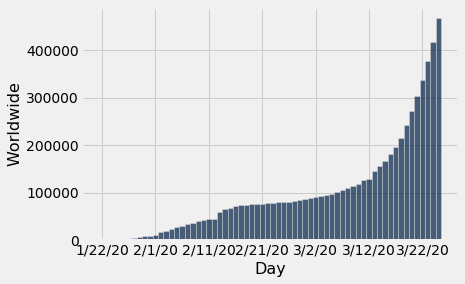

In [10]:
total_confirmed = countries_by_day.select('Day')
total_confirmed['Worldwide'] = countries_by_day.sum_rows()
print('Total confirmed', total_confirmed.last('Worldwide'))
total_confirmed.obar()

## Global confirmed cases by country - largest

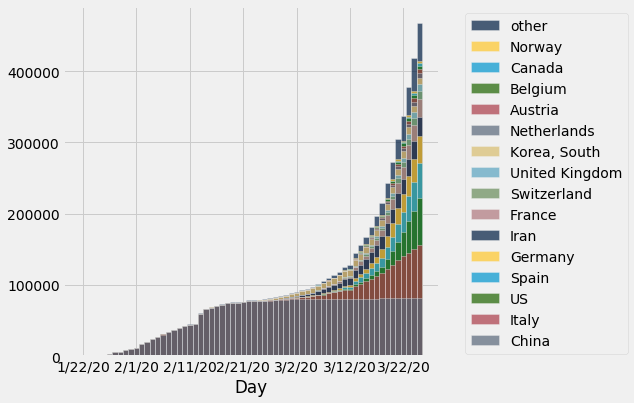

In [11]:
# Breaking this picture down by largest caseloads

countries_by_day.stackbar(15, height=6)

In [12]:
# Recent worldwide growth trend - past week
total_confirmed.trend().take[-7:]

Day,Worldwide,new,% new,rate
3/19/20,242500,27679,12.88%,1.12885
3/20/20,272035,29535,12.18%,1.12179
3/21/20,304396,32361,11.90%,1.11896
3/22/20,336953,32557,10.70%,1.10696
3/23/20,378235,41282,12.25%,1.12252
3/24/20,418045,39810,10.53%,1.10525
3/25/20,467593,49548,11.85%,1.11852


## Global picture sans China

The global growth rate above is somewhat optimistic, since the growth across the world is amortized over the substantial, but flat, cases in China, now mostly resolved.  Removing that we see a more accurate picture of the trends

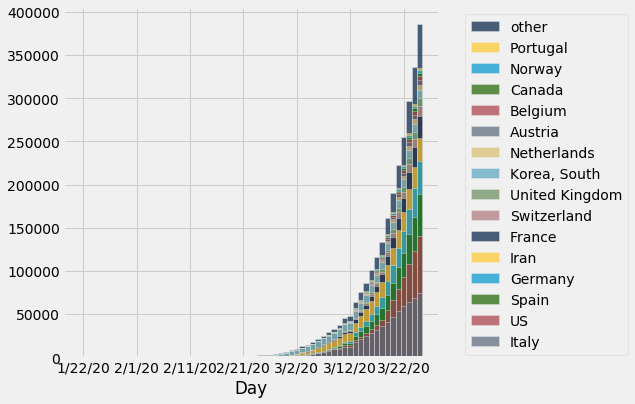

In [13]:
# Taking China out of the picture
sans_china_by_day = countries_by_day.drop('China')
sans_china_by_day.stackbar(15, height=6)

In [14]:
sans_china_confirmed = sans_china_by_day.select('Day')
sans_china_confirmed['Worldwide sans China'] = sans_china_by_day.sum_rows()
sans_china_confirmed.trend().take[-15:].show()

Day,Worldwide sans China,new,% new,rate
3/11/20,44954,7221,19.14%,1.19137
3/12/20,47420,2466,5.49%,1.05486
3/13/20,64260,16840,35.51%,1.35512
3/14/20,75124,10864,16.91%,1.16906
3/15/20,86451,11327,15.08%,1.15078
3/16/20,100541,14090,16.30%,1.16298
3/17/20,116044,15503,15.42%,1.1542
3/18/20,133719,17675,15.23%,1.15231
3/19/20,161344,27625,20.66%,1.20659
3/20/20,190785,29441,18.25%,1.18247


## Projecting global trends two weeks out

The following indicates confirmed cases for the two weeks ahead.

In [15]:
project_trend(total_confirmed.trend().take[-10:], 14).show()

Day,Worldwide,new,% new,rate
3/16/20,181574,14120,0.0843217,1.08432
3/17/20,197102,15528,0.0855189,1.08552
3/18/20,214821,17719,0.0898976,1.0899
3/19/20,242500,27679,0.128847,1.12885
3/20/20,272035,29535,0.121794,1.12179
3/21/20,304396,32361,0.118959,1.11896
3/22/20,336953,32557,0.106956,1.10696
3/23/20,378235,41282,0.122516,1.12252
3/24/20,418045,39810,0.105252,1.10525
3/25/20,467593,49548,0.118523,1.11852


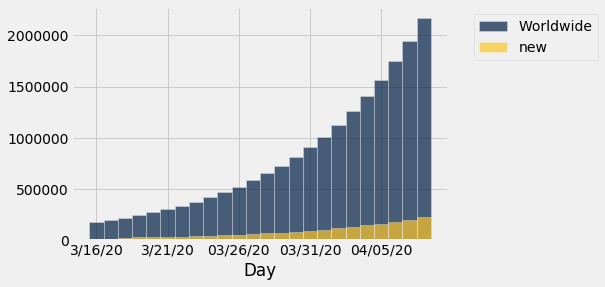

In [16]:
project_trend(total_confirmed.trend().take[-10:], 14).select(range(3)).bar('Day')

Assuming China stays flat and using the growth rate of the rest of the world, we get a more concerning picture.

In [17]:
project_trend(sans_china_confirmed.trend().take[-10:], 14).show()

Day,Worldwide sans China,new,% new,rate
3/16/20,100541,14090,0.162982,1.16298
3/17/20,116044,15503,0.154196,1.1542
3/18/20,133719,17675,0.152313,1.15231
3/19/20,161344,27625,0.20659,1.20659
3/20/20,190785,29441,0.182473,1.18247
3/21/20,223091,32306,0.169332,1.16933
3/22/20,255518,32427,0.145353,1.14535
3/23/20,296737,41219,0.161315,1.16132
3/24/20,336454,39717,0.133846,1.13385
3/25/20,385932,49478,0.147057,1.14706


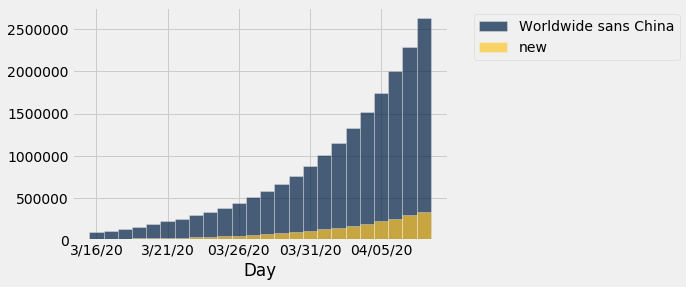

In [18]:
project_trend(sans_china_confirmed.trend().take[-10:], 14).select(range(3)).bar('Day')

# Country level trends

Recent confirmed cases on a country by country basis.

In [19]:
countries_by_day.top(15).take[-10:]

Day,China,Italy,US,Spain,Germany,Iran,France,Switzerland,United Kingdom,"Korea, South",Netherlands,Austria,Belgium,Canada,Norway
3/16/20,81033,27980,4632,9942,7272,14991,6683,2200,1551,8236,1416,1018,1058,415,1333
3/17/20,81058,31506,6421,11748,9257,16169,7715,2700,1960,8320,1711,1332,1243,478,1463
3/18/20,81102,35713,7783,13910,12327,17361,9124,3028,2642,8413,2058,1646,1486,657,1550
3/19/20,81156,41035,13677,17963,15320,18407,10970,4075,2716,8565,2467,2013,1795,800,1746
3/20/20,81250,47021,19100,20410,19848,19644,12758,5294,4014,8652,3003,2388,2257,943,1914
3/21/20,81305,53578,25489,25374,22213,20610,14463,6575,5067,8799,3640,2814,2815,1277,2118
3/22/20,81435,59138,33276,28768,24873,21638,16243,7474,5745,8961,4217,3582,3401,1469,2385
3/23/20,81498,63927,43847,35136,29056,23049,20123,8795,6726,8961,4764,4474,3743,2088,2621
3/24/20,81591,69176,53740,39885,32986,24811,22622,9877,8164,9037,5580,5283,4269,2790,2863
3/25/20,81661,74386,65778,49515,37323,27017,25600,10897,9640,9137,6438,5588,4937,3251,3084


In [20]:
countries_by_day.top(5).trend().take[-10:]

Day,China,new China,% newChina,rate China,Italy,new Italy,% newItaly,rate Italy,US,new US,% newUS,rate US,Spain,new Spain,% newSpain,rate Spain,Germany,new Germany,% newGermany,rate Germany
3/16/20,81033,30,0.04%,1.00037,27980,3233,11.55%,1.13064,4632,1133,24.46%,1.32381,9942,2144,21.57%,1.27494,7272,1477,20.31%,1.25487
3/17/20,81058,25,0.03%,1.00031,31506,3526,11.19%,1.12602,6421,1789,27.86%,1.38623,11748,1806,15.37%,1.18165,9257,1985,21.44%,1.27296
3/18/20,81102,44,0.05%,1.00054,35713,4207,11.78%,1.13353,7783,1362,17.50%,1.21212,13910,2162,15.54%,1.18403,12327,3070,24.90%,1.33164
3/19/20,81156,54,0.07%,1.00067,41035,5322,12.97%,1.14902,13677,5894,43.09%,1.75729,17963,4053,22.56%,1.29137,15320,2993,19.54%,1.2428
3/20/20,81250,94,0.12%,1.00116,47021,5986,12.73%,1.14588,19100,5423,28.39%,1.39651,20410,2447,11.99%,1.13622,19848,4528,22.81%,1.29556
3/21/20,81305,55,0.07%,1.00068,53578,6557,12.24%,1.13945,25489,6389,25.07%,1.3345,25374,4964,19.56%,1.24321,22213,2365,10.65%,1.11916
3/22/20,81435,130,0.16%,1.0016,59138,5560,9.40%,1.10377,33276,7787,23.40%,1.3055,28768,3394,11.80%,1.13376,24873,2660,10.69%,1.11975
3/23/20,81498,63,0.08%,1.00077,63927,4789,7.49%,1.08098,43847,10571,24.11%,1.31768,35136,6368,18.12%,1.22136,29056,4183,14.40%,1.16817
3/24/20,81591,93,0.11%,1.00114,69176,5249,7.59%,1.08211,53740,9893,18.41%,1.22563,39885,4749,11.91%,1.13516,32986,3930,11.91%,1.13526
3/25/20,81661,70,0.09%,1.00086,74386,5210,7.00%,1.07532,65778,12038,18.30%,1.224,49515,9630,19.45%,1.24144,37323,4337,11.62%,1.13148


In [21]:
final_trend = countries_by_day.trend().take[-1:]
final_trend

Day,Afghanistan,new Afghanistan,% newAfghanistan,rate Afghanistan,Albania,new Albania,% newAlbania,rate Albania,Algeria,new Algeria,% newAlgeria,rate Algeria,Andorra,new Andorra,% newAndorra,rate Andorra,Angola,new Angola,% newAngola,rate Angola,Antigua and Barbuda,new Antigua and Barbuda,% newAntigua and Barbuda,rate Antigua and Barbuda,Argentina,new Argentina,% newArgentina,rate Argentina,Armenia,new Armenia,% newArmenia,rate Armenia,Australia,new Australia,% newAustralia,rate Australia,Austria,new Austria,% newAustria,rate Austria,Azerbaijan,new Azerbaijan,% newAzerbaijan,rate Azerbaijan,Bahamas,new Bahamas,% newBahamas,rate Bahamas,Bahrain,new Bahrain,% newBahrain,rate Bahrain,Bangladesh,new Bangladesh,% newBangladesh,rate Bangladesh,Barbados,new Barbados,% newBarbados,rate Barbados,Belarus,new Belarus,% newBelarus,rate Belarus,Belgium,new Belgium,% newBelgium,rate Belgium,Belize,new Belize,% newBelize,rate Belize,Benin,new Benin,% newBenin,rate Benin,Bhutan,new Bhutan,% newBhutan,rate Bhutan,Bolivia,new Bolivia,% newBolivia,rate Bolivia,Bosnia and Herzegovina,new Bosnia and Herzegovina,% newBosnia and Herzegovina,rate Bosnia and Herzegovina,Brazil,new Brazil,% newBrazil,rate Brazil,Brunei,new Brunei,% newBrunei,rate Brunei,Bulgaria,new Bulgaria,% newBulgaria,rate Bulgaria,Burkina Faso,new Burkina Faso,% newBurkina Faso,rate Burkina Faso,Cabo Verde,new Cabo Verde,% newCabo Verde,rate Cabo Verde,Cambodia,new Cambodia,% newCambodia,rate Cambodia,Cameroon,new Cameroon,% newCameroon,rate Cameroon,Canada,new Canada,% newCanada,rate Canada,Central African Republic,new Central African Republic,% newCentral African Republic,rate Central African Republic,Chad,new Chad,% newChad,rate Chad,Chile,new Chile,% newChile,rate Chile,China,new China,% newChina,rate China,Colombia,new Colombia,% newColombia,rate Colombia,Congo (Brazzaville),new Congo (Brazzaville),% newCongo (Brazzaville),rate Congo (Brazzaville),Congo (Kinshasa),new Congo (Kinshasa),% newCongo (Kinshasa),rate Congo (Kinshasa),Costa Rica,new Costa Rica,% newCosta Rica,rate Costa Rica,Cote d'Ivoire,new Cote d'Ivoire,% newCote d'Ivoire,rate Cote d'Ivoire,Croatia,new Croatia,% newCroatia,rate Croatia,Cuba,new Cuba,% newCuba,rate Cuba,Cyprus,new Cyprus,% newCyprus,rate Cyprus,Czechia,new Czechia,% newCzechia,rate Czechia,Denmark,new Denmark,% newDenmark,rate Denmark,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Djibouti,new Djibouti,% newDjibouti,rate Djibouti,Dominica,new Dominica,% newDominica,rate Dominica,Dominican Republic,new Dominican Republic,% newDominican Republic,rate Dominican Republic,Ecuador,new Ecuador,% newEcuador,rate Ecuador,Egypt,new Egypt,% newEgypt,rate Egypt,El Salvador,new El Salvador,% newEl Salvador,rate El Salvador,Equatorial Guinea,new Equatorial Guinea,% newEquatorial Guinea,rate Equatorial Guinea,Eritrea,new Eritrea,% newEritrea,rate Eritrea,Estonia,new Estonia,% newEstonia,rate Estonia,Eswatini,new Eswatini,% newEswatini,rate Eswatini,Ethiopia,new Ethiopia,% newEthiopia,rate Ethiopia,Fiji,new Fiji,% newFiji,rate Fiji,Finland,new Finland,% newFinland,rate Finland,France,new France,% newFrance,rate France,Gabon,new Gabon,% newGabon,rate Gabon,Gambia,new Gambia,% newGambia,rate Gambia,Georgia,new Georgia,% newGeorgia,rate Georgia,Germany,new Germany,% newGermany,rate Germany,Ghana,new Ghana,% newGhana,rate Ghana,Greece,new Greece,% newGreece,rate Greece,Grenada,new Grenada,% newGrenada,rate Grenada,Guatemala,new Guatemala,% newGuatemala,rate Guatemala,Guinea,new Guinea,% newGuinea,rate Guinea,Guinea-Bissau,new Guinea-Bissau,% newGuinea-Bissau,rate Guinea-Bissau,Guyana,new Guyana,% newGuyana,rate Guyana,Haiti,new Haiti,% newHaiti,rate Haiti,Holy See,new Holy See,% newHoly See,rate Holy See,Honduras,new Honduras,% newHonduras,rate Honduras,Hungary,new Hungary,% newHungary,rate Hungary,Iceland,new Iceland,% newIceland,rate Iceland,India,new India,% newIndia,rate India,Indonesia,new Indonesia,% newIndonesia,rate Indonesi

In [22]:
def countries(raw_world):
    """Country level metadata from the raw source"""
    res = raw_world.select(['Country/Region', 'Lat', 'Long']).group('Country/Region', np.mean)
    return res

def get_new(trend, country):
    return trend['new ' + country][-1]

In [40]:
country_summary = countries(raw_confirmed).join('Country/Region', raw_by_country.select(['Country/Region', last_day]))
country_summary['new'] = country_summary.apply(lambda c: get_new(final_trend, c), 'Country/Region')
country_summary['growth'] = country_summary['new'] / country_summary[last_day]
country_summary = country_summary.where(country_summary['new'] >= 0)

In [41]:
country_summary.sort('growth', descending=True).show()

Country/Region,Lat mean,Long mean,3/25/20,new,growth
Saint Kitts and Nevis,17.3578,-62.783,2,2,1
Mali,17.5707,-3.99617,2,2,1
Guinea-Bissau,11.8037,-15.1804,2,2,1
Syria,34.8021,38.9968,5,4,0.8
Zambia,-15.4167,28.2833,12,9,0.75
Eritrea,15.1794,39.7823,4,3,0.75
Djibouti,11.8251,42.5903,11,8,0.727273
Dominica,15.415,-61.371,7,5,0.714286
Niger,17.6078,8.0817,7,4,0.571429
Belize,13.1939,-59.5432,2,1,0.5


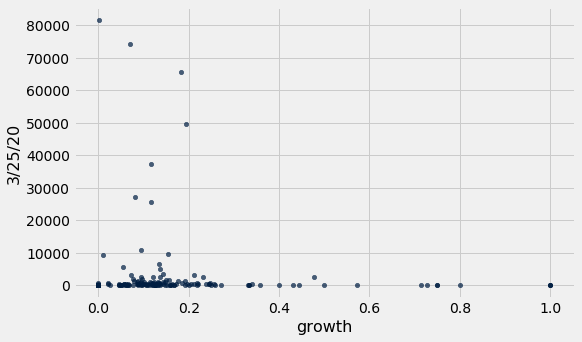

In [42]:
country_summary.where(country_summary['growth']>=0).select([last_day, 'growth']).scatter('growth', width=8)

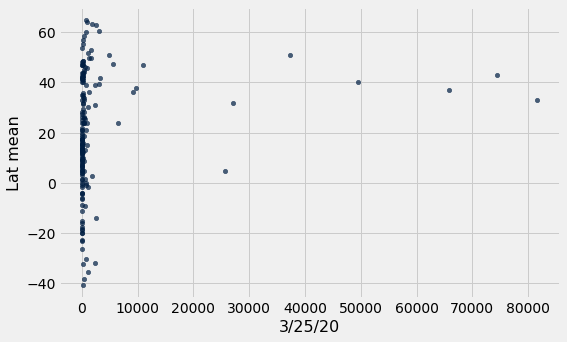

In [43]:
country_summary.where(country_summary['growth']>=0).select([last_day, 'Lat mean']).scatter(last_day, width=8)

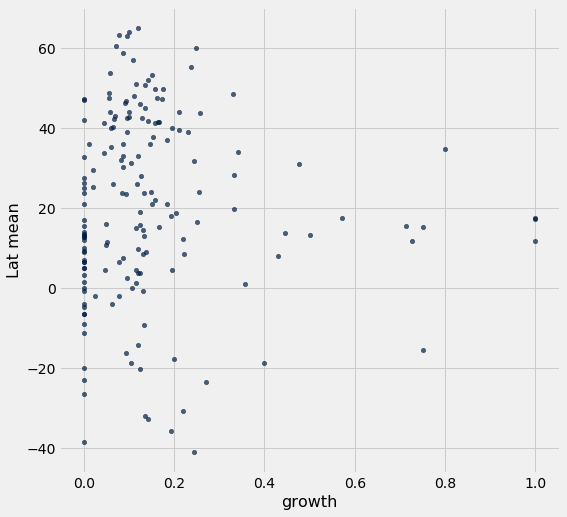

In [44]:
country_summary.where(country_summary['growth']>=0).select(['growth', 'Lat mean']).scatter('growth', width=8, height=8)

### Confirmed cases in one country

In [45]:
w = widgets.Dropdown(
    options=countries_by_day.categories,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
w

Dropdown(description='Country:', index=162, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',…

In [46]:
country = w.value

In [47]:
country_trend = countries_by_day.extract(country).trend()
country_trend.following('3/11/20').show()

Day,US,new,% new,rate
3/11/20,1281,322,0.335766,1.33577
3/12/20,1663,382,0.298205,1.2982
3/13/20,2179,516,0.310283,1.31028
3/14/20,2727,548,0.251492,1.25149
3/15/20,3499,772,0.283095,1.28309
3/16/20,4632,1133,0.323807,1.32381
3/17/20,6421,1789,0.386226,1.38623
3/18/20,7783,1362,0.212116,1.21212
3/19/20,13677,5894,0.757292,1.75729
3/20/20,19100,5423,0.396505,1.39651


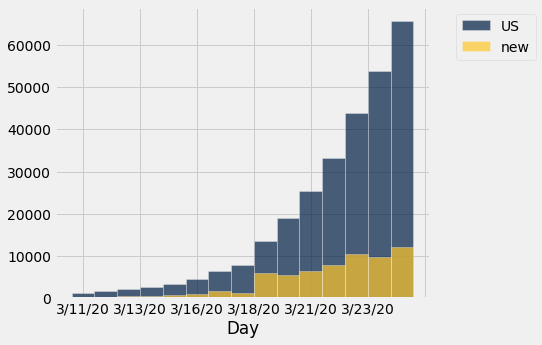

In [48]:
recent = country_trend.following('3/11/20')
recent.extract([country, 'new']).bar('Day', height=5)

In [49]:
projection = project_trend(recent, 14)
projection.show()

Day,US,new,% new,rate
3/11/20,1281,322,0.335766,1.33577
3/12/20,1663,382,0.298205,1.2982
3/13/20,2179,516,0.310283,1.31028
3/14/20,2727,548,0.251492,1.25149
3/15/20,3499,772,0.283095,1.28309
3/16/20,4632,1133,0.323807,1.32381
3/17/20,6421,1789,0.386226,1.38623
3/18/20,7783,1362,0.212116,1.21212
3/19/20,13677,5894,0.757292,1.75729
3/20/20,19100,5423,0.396505,1.39651


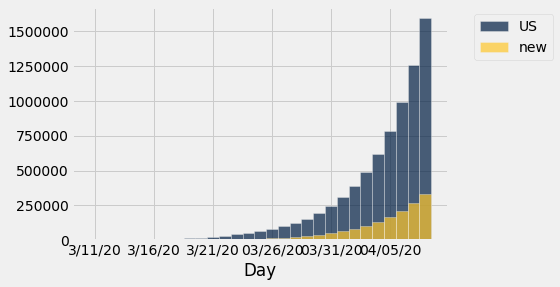

In [50]:
projection.extract([country, 'new']).bar('Day')